## The Battle of Neighborhoods - Toronto

### Importing Required Libraries

In [1]:
!pip install bs4
from bs4 import BeautifulSoup # this module helps in web scrapping.
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1


### Data Collection:

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text

In [3]:
soup = BeautifulSoup(data,"html5lib")

In [4]:
table=soup.find('table')

In [5]:
table_contents=[]
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df = pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
df.shape

(103, 3)

In [7]:
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [8]:
geo_df=pd.read_csv('https://cocl.us/Geospatial_data')

In [9]:
geo_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [10]:
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [11]:
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [12]:
df = pd.merge(df,geo_df, on='PostalCode')

In [15]:
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [16]:
df.shape

(103, 5)

In [17]:
toronto_data = df

In [18]:
toronto_data.shape

(103, 5)

 ### Foursquare credentials

In [19]:
CLIENT_ID = 'WRLCRJDXRVZZNA1SAFL214NQVWDRYI354QCRGHPGISCB04P0' # your Foursquare ID
CLIENT_SECRET = 'BOFNZD5UMRC2TD0004R2HFTVGSC4RVFPR5VXIAZDGMFMHRP2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WRLCRJDXRVZZNA1SAFL214NQVWDRYI354QCRGHPGISCB04P0
CLIENT_SECRET:BOFNZD5UMRC2TD0004R2HFTVGSC4RVFPR5VXIAZDGMFMHRP2


## Explore Neighborhoods in Toronto

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [22]:
print(toronto_venues.shape)
toronto_venues.head()

(2130, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1   Fast Food Restaurant  
2      Food & Drink Shop  
3           Hockey Arena  
4  Portuguese Restaurant

In [23]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  9   
Bathurst Manor, Wilson Heights, Downsview North                        23   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      25   
Berczy Park                                                            60   
Birch Cliff, Cliffside West                                             5   
Brockton, Parkdale Village, Exhibition Place                           23   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               8   
Central Bay Street                                                     60   
Christie                                                               15   
Church and Wellesley                                                   77   
Clairville, Humberwood, Woodbine Downs, West Hu...                      5   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             36   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         4   
Don Mills South                                                        19   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview Central                                                       3   
Downsview East                                                          3   
Downsview Northwest                                                     4   
Downsview West                                                          4   
Dufferin, Dovercourt Village                                           16   
Enclave of L4W                                                         13   
Enclave of M4L                                                         15   
Enclave of M5E                                                        100   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           66   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               5   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          24   
Hillcrest Village                                                       5   
Humber Summit                                                           3   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         21   
Kennedy Park, Ionview, East Birchmount Park                             5   
Kensington Market, Chinatown, Grange Park                              60   
Kingsview Village, St. Phillips, Martin Grove G...                      3   
Lawrence Manor, Lawrence Heights                

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


In [25]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Analysis

**First, lets visualize the number of venues obtained in all the neighborhoods**

<AxesSubplot:xlabel='Neighborhood'>

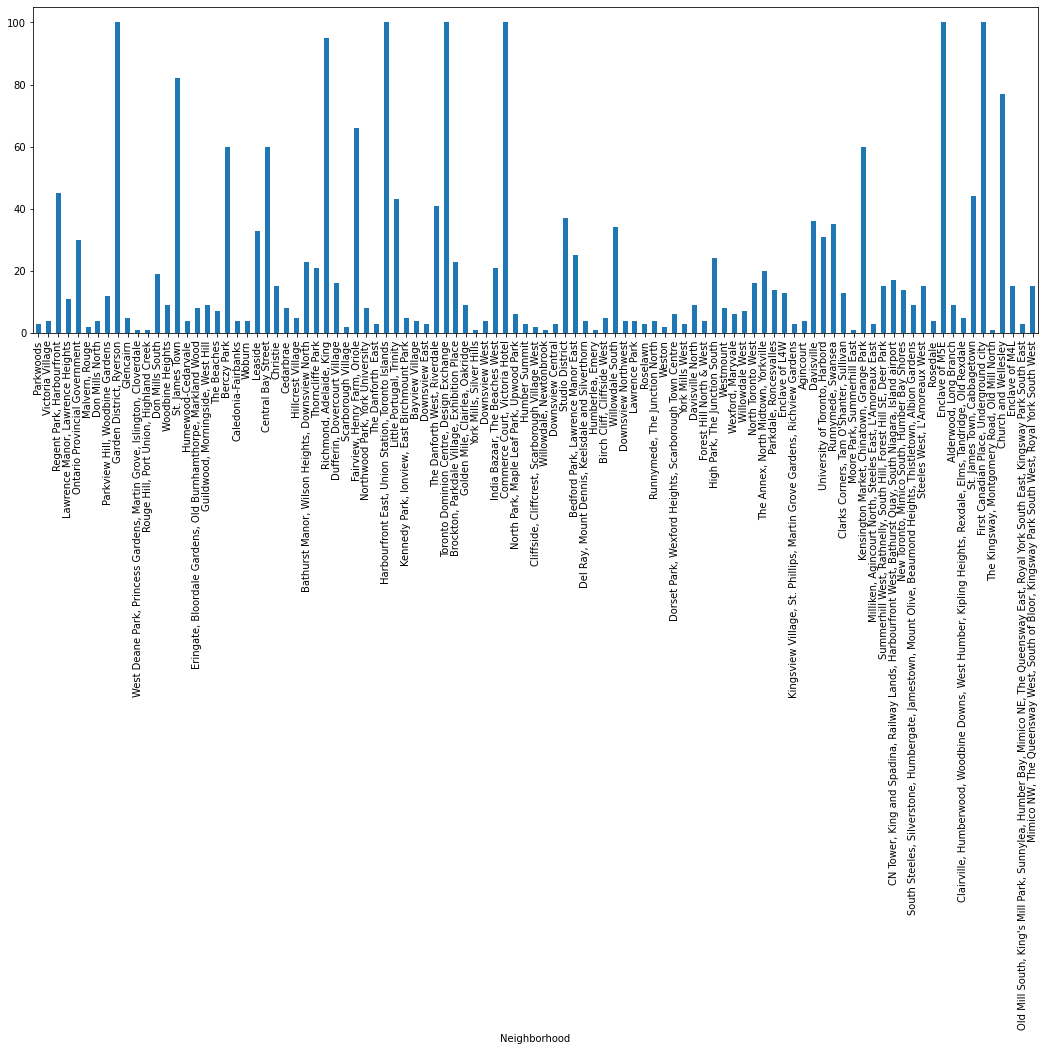

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

df = toronto_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

**As we can see from the above bar chart, there are many neighborhoods with less than 5 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 5 or more than 5 venues were obtained.**

<AxesSubplot:xlabel='Neighborhood'>

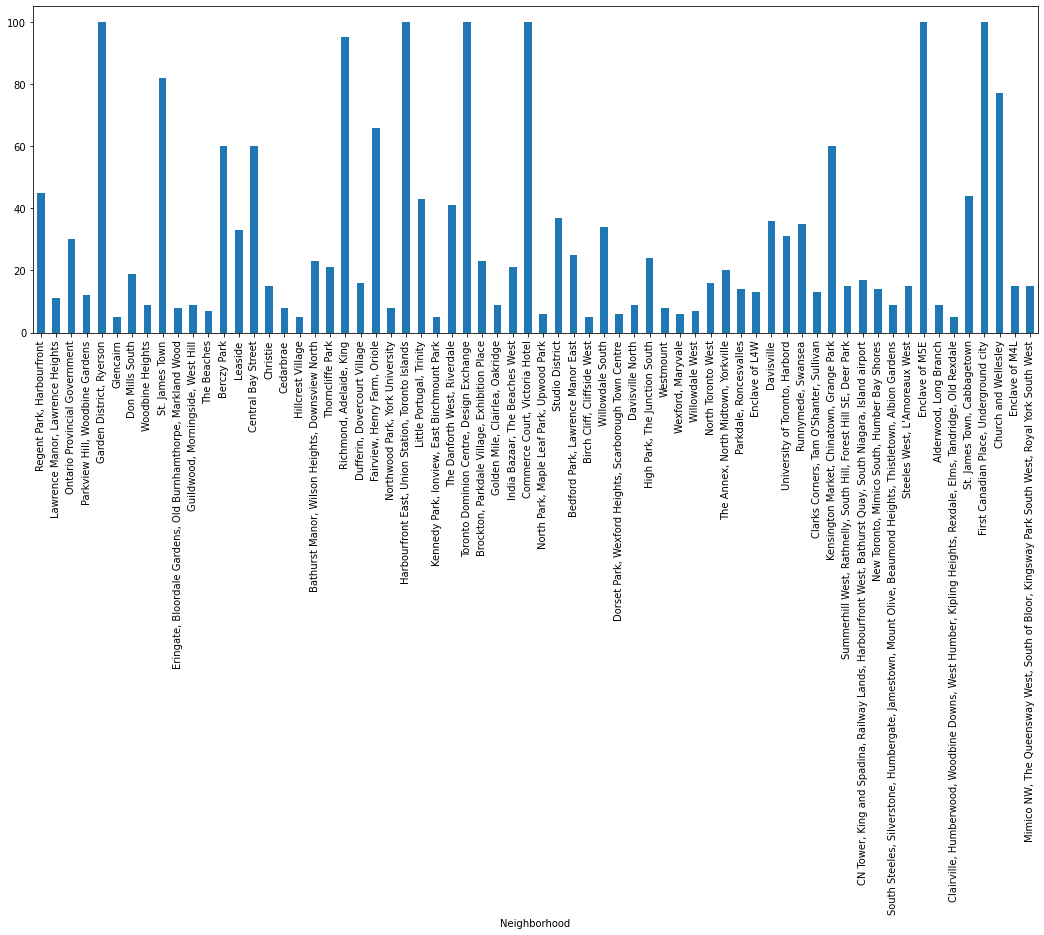

In [29]:
df = df[df >= 5]
df.plot.bar(figsize=(18,6))

**Lets create a new dataframe that contains only the neighborhoods with 5+ venues and the venues with their details included.**

In [30]:
toronto_venues_top = toronto_venues[toronto_venues['Neighborhood'].isin(df.index.tolist())]
toronto_venues_top.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
7   Regent Park, Harbourfront               43.65426              -79.360636   
8   Regent Park, Harbourfront               43.65426              -79.360636   
9   Regent Park, Harbourfront               43.65426              -79.360636   
10  Regent Park, Harbourfront               43.65426              -79.360636   
11  Regent Park, Harbourfront               43.65426              -79.360636   

                     Venue  Venue Latitude  Venue Longitude  \
7         Roselle Desserts       43.653447       -79.362017   
8            Tandem Coffee       43.653559       -79.361809   
9   Cooper Koo Family YMCA       43.653249       -79.358008   
10     Body Blitz Spa East       43.654735       -79.359874   
11          Impact Kitchen       43.656369       -79.356980   

         Venue Category  
7                Bakery  
8           Coffee Shop  
9   Distribution Center  
10                  Spa  
11           Restaurant

In [31]:
toronto_venues_top.reset_index(drop=True,inplace=True)

In [32]:
toronto_venues_top.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0        Roselle Desserts       43.653447       -79.362017   
1           Tandem Coffee       43.653559       -79.361809   
2  Cooper Koo Family YMCA       43.653249       -79.358008   
3     Body Blitz Spa East       43.654735       -79.359874   
4          Impact Kitchen       43.656369       -79.356980   

        Venue Category  
0               Bakery  
1          Coffee Shop  
2  Distribution Center  
3                  Spa  
4           Restaurant

### one hot encoding

In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_top[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True)
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues_top['Neighborhood'] )
toronto_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  \
0  Regent Park, Harbourfront                  0               0   
1  Regent Park, Harbourfront                  0               0   
2  Regent Park, Harbourfront                  0               0   
3  Regent Park, Harbourfront                  0               0   
4  Regent Park, Harbourfront                  0               0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                  0        0                   0               0   
1                  0        0                   0               0   
2                  0        0                   0               0   
3                  0        0                   0               0   
4                  0        0                   0               0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0                0                 0                    0             0   
1                0                 0                    0             0   
2                0                 0                    0             0   
3                0                 0                    0             0   
4                0                 0                    0             0   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0         0            0           0                    0                 0   
1         0            0           0                    0                 0   
2         0            0           0                    0                 0   
3         0            0           0                    0                 0   
4         0            0           0                    0                 0   

   Athletics & Sports  Auto Garage  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0                   0            0          0           0           0       1   
1                   0            0          0           0           0       0   
2                   0            0          0           0           0       0   
3                   0            0          0           0           0       0   
4                   0            0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    0               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                   0      0                0         0           0   
1                   0      0                0         0           0   
2                   0      0                0         0           0   
3                   0      0                0         0           0   
4                   0      0                0         0           0   

   Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                   0          0       0              0          0         0   
1                   0          0       0              0          0         0   
2                   0          0       0              0          0         0   
3                   0          0       0              0          0         0   
4                   0          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  Bus Station  \
0  

In [34]:
toronto_onehot.shape

(2029, 262)

In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Accessories Store  \
0                           Alderwood, Long Branch                0.0   
1  Bathurst Manor, Wilson Heights, Downsview North                0.0   
2                Bedford Park, Lawrence Manor East                0.0   
3                                      Berczy Park                0.0   
4                      Birch Cliff, Cliffside West                0.0   

   Adult Boutique  Afghan Restaurant  Airport  Airport Food Court  \
0             0.0                0.0      0.0                 0.0   
1             0.0                0.0      0.0                 0.0   
2             0.0                0.0      0.0                 0.0   
3             0.0                0.0      0.0                 0.0   
4             0.0                0.0      0.0                 0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0                 0.00   
1             0.0              0.0               0.0                 0.00   
2             0.0              0.0               0.0                 0.04   
3             0.0              0.0               0.0                 0.00   
4             0.0              0.0               0.0                 0.00   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0     0.000000         0.0                  0.0   
1           0.0       0.0     0.000000         0.0                  0.0   
2           0.0       0.0     0.000000         0.0                  0.0   
3           0.0       0.0     0.016667         0.0                  0.0   
4           0.0       0.0     0.000000         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  BBQ Joint  Baby Store  \
0               0.0            0.111111          0.0        0.0         0.0   
1               0.0            0.000000          0.0        0.0         0.0   
2               0.0            0.000000          0.0        0.0         0.0   
3               0.0            0.000000          0.0        0.0         0.0   
4               0.0            0.000000          0.0        0.0         0.0   

   Bagel Shop  Bakery      Bank  Bar  Baseball Field  Baseball Stadium  \
0    0.000000    0.00  0.000000  0.0             0.0               0.0   
1    0.000000    0.00  0.086957  0.0             0.0               0.0   
2    0.000000    0.00  0.000000  0.0             0.0               0.0   
3    0.016667    0.05  0.000000  0.0             0.0               0.0   
4    0.000000    0.00  0.000000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium     Beach  Bed & Breakfast  Beer Bar  \
0               0.0            0.000000  0.000000              0.0  0.000000   
1               0.0            0.000000  0.000000              0.0  0.000000   
2               0.0            0.000000  0.000000              0.0  0.000000   
3               0.0            0.016667  0.016667              0.0  0.033333   
4               0.0            0.000000  0.000000              0.0  0.000000   

   Beer Store  Belgian Restaurant  Bike Shop    Bistro  Boat or Ferry  \
0         0.0                 0.0        0.0  0.000000            0.0   
1         0.0                 0.0        0.0  0.000000            0.0   
2         0.0                 0.0        0.0  0.000000            0.0   
3         0.0                 0.0        0.0  0.016667            0.0   
4         0.0                 0.0        0.0  0.000000            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0        0.000000      0.0   
1        0.0       0.0                   0.0        0.000000      0.0   
2        0.0       0.0                   0.0        0.040000      0.0   
3        0.0       0.0                   0.0        0.016667      0.0   
4        0.0       0.0                   0.0        0.000000     

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### 10 most common venues

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                           Alderwood, Long Branch           Pizza Place   
1  Bathurst Manor, Wilson Heights, Downsview North                  Bank   
2                Bedford Park, Lawrence Manor East           Coffee Shop   
3                                      Berczy Park           Coffee Shop   
4                      Birch Cliff, Cliffside West       College Stadium   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0              Pharmacy                   Pub         Sandwich Place   
1           Coffee Shop           Bridal Shop         Sandwich Place   
2    Italian Restaurant        Sandwich Place             Restaurant   
3          Cocktail Bar                Bakery         Farmers Market   
4          Skating Rink                  Café  General Entertainment   

  5th Most Common Venue     6th Most Common Venue 7th Most Common Venue  \
0    Athletics & Sports               Coffee Shop            Playground   
1    Frozen Yogurt Shop          Sushi Restaurant    Chinese Restaurant   
2           Pizza Place                      Café      Sushi Restaurant   
3    Seafood Restaurant                  Pharmacy           Cheese Shop   
4                  Farm  Mediterranean Restaurant        Medical Center   

  8th Most Common Venue 9th Most Common Venue    10th Most Common Venue  
0                   Gym        Medical Center  Mediterranean Restaurant  
1            Restaurant           Gas Station                     Diner  
2             Juice Bar              Pharmacy              Liquor Store  
3              Beer Bar            Restaurant   Comfort Food Restaurant  
4           Men's Store         Metro Station       Monument / Landmark

## Cluster Neighborhoods

#### Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.

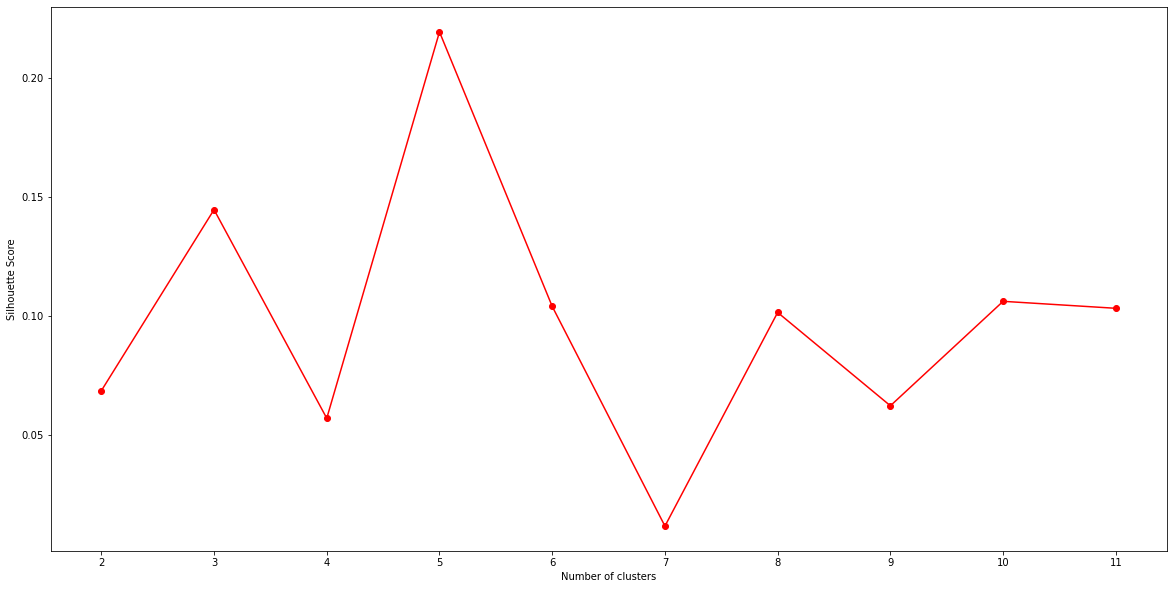

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

max_score = 12
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(toronto_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(toronto_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

**As seen from the above line plot, the best number of clusters having the highest silhouette score is 5. So, lets consider the number of clusters as 5.**

In [40]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_venues_top

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0        Roselle Desserts       43.653447       -79.362017   
1           Tandem Coffee       43.653559       -79.361809   
2  Cooper Koo Family YMCA       43.653249       -79.358008   
3     Body Blitz Spa East       43.654735       -79.359874   
4          Impact Kitchen       43.656369       -79.356980   

        Venue Category  Cluster Labels 1st Most Common Venue  \
0               Bakery               3           Coffee Shop   
1          Coffee Shop               3           Coffee Shop   
2  Distribution Center               3           Coffee Shop   
3                  Spa               3           Coffee Shop   
4           Restaurant               3           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery                  Park        Breakfast Spot   
1                Bakery                  Park        Breakfast Spot   
2                Bakery                  Park        Breakfast Spot   
3                Bakery                  Park        Breakfast Spot   
4                Bakery                  Park        Breakfast Spot   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                  Café               Theater                   Pub   
1                  Café               Theater                   Pub   
2                  Café               Theater                   Pub   
3                  Café               Theater                   Pub   
4                  Café               Theater                   Pub   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0        Farmers Market        Chocolate Shop         Cosmetics Shop  
1        Farmers Market        Chocolate Shop         Cosmetics Shop  
2        Farmers Market        Chocolate Shop         Cosmetics Shop  
3        Farmers Market        Chocolate Shop         Cosmetics Shop  
4        Farmers Market        Chocolate Shop         Cosmetics Shop

In [44]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Map of Toronto with the clusters superimposed on top
This map can be used to find a suitable location to start a new business based on the category.

In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results 

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

**Cluster 1**

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighborhood  Venue Latitude  \
1773  Clairville, Humberwood, Woodbine Downs, West H...       43.708471   
1774  Clairville, Humberwood, Woodbine Downs, West H...       43.707554   
1775  Clairville, Humberwood, Woodbine Downs, West H...       43.705072   
1776  Clairville, Humberwood, Woodbine Downs, West H...       43.706539   
1777  Clairville, Humberwood, Woodbine Downs, West H...       43.704891   

      Venue Longitude       Venue Category  Cluster Labels  \
1773       -79.589943  Rental Car Location               0   
1774       -79.589252                  Bar               0   
1775       -79.598725            Drugstore               0   
1776       -79.599359        Garden Center               0   
1777       -79.599410           Truck Stop               0   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
1773         Garden Center            Truck Stop                   Bar   
1774         Garden Center            Truck Stop                   Bar   
1775         Garden Center            Truck Stop                   Bar   
1776         Garden Center            Truck Stop                   Bar   
1777         Garden Center            Truck Stop                   Bar   

     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
1773   Rental Car Location             Drugstore        Medical Center   
1774   Rental Car Location             Drugstore        Medical Center   
1775   Rental Car Location             Drugstore        Medical Center   
1776   Rental Car Location             Drugstore        Medical Center   
1777   Rental Car Location             Drugstore        Medical Center   

         7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
1773  Mediterranean Restaurant           Men's Store         Metro Station   
1774  Mediterranean Restaurant           Men's Store         Metro Station   
1775  Mediterranean Restaurant           Men's Store         Metro Station   
1776  Mediterranean Restaurant           Men's Store         Metro Station   
1777  Mediterranean Restaurant           Men's Store         Metro Station   

               10th Most Common Venue  
1773  Molecular Gastronomy Restaurant  
1774  Molecular Gastronomy Restaurant  
1775  Molecular Gastronomy Restaurant  
1776  Molecular Gastronomy Restaurant  
1777  Molecular Gastronomy Restaurant

In [63]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Drugstore                          5
Rental Car Location                5
Mediterranean Restaurant           5
Men's Store                        5
Bar                                5
Medical Center                     5
Molecular Gastronomy Restaurant    5
Metro Station                      5
Garden Center                      5
Truck Stop                         5
dtype: int64


**Cluster 2**

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighborhood  Venue Latitude  \
198                                  Glencairn       43.707420   
199                                  Glencairn       43.709111   
200                                  Glencairn       43.708828   
201                                  Glencairn       43.707170   
202                                  Glencairn       43.713550   
330                                The Beaches       43.676821   
331                                The Beaches       43.678879   
332                                The Beaches       43.679181   
333                                The Beaches       43.675278   
334                                The Beaches       43.680563   
335                                The Beaches       43.678897   
336                                The Beaches       43.678888   
1189  North Park, Maple Leaf Park, Upwood Park       43.715414   
1190  North Park, Maple Leaf Park, Upwood Park       43.715548   
1191  North Park, Maple Leaf Park, Upwood Park       43.716503   
1192  North Park, Maple Leaf Park, Upwood Park       43.716188   
1193  North Park, Maple Leaf Park, Upwood Park       43.712355   
1194  North Park, Maple Leaf Park, Upwood Park       43.714068   

      Venue Longitude              Venue Category  Cluster Labels  \
198        -79.443126                      Bakery               1   
199        -79.443930         Japanese Restaurant               1   
200        -79.443366            Asian Restaurant               1   
201        -79.442658                 Pizza Place               1   
202        -79.442482                        Park               1   
330        -79.293942                       Trail               1   
331        -79.297734           Health Food Store               1   
332        -79.297215                         Pub               1   
333        -79.294647                        Park               1   
334        -79.292869                Neighborhood               1   
335        -79.297745                 Coffee Shop               1   
336        -79.298167            Asian Restaurant               1   
1189       -79.490300                      Bakery               1   
1190       -79.489870               Deli / Bodega               1   
1191       -79.489838            Basketball Court               1   
1192       -79.493531                        Park               1   
1193       -79.484754                       Trail               1   
1194       -79.496113  Construction & Landscaping               1   

           1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
198                       Bakery           Pizza Place                  Park   
199                       Bakery           Pizza Place                  Park   
200                       Bakery           Pizza Place                  Park   
201                       Bakery           Pizza Place                  Park   
202                       Bakery           Pizza Place                  Park   
330                          Pub                 Trail     Health Food Store   
331                          Pub                 Trail     Health Food Store   
332                          Pub                 Trail     Health Food Store   
333                          Pub                 Trail     Health Food Store   
334                          Pub                 Trail     Health Food Store   
335                          Pub                 Trail     Health Food Store   
336                          Pub                 Trail     Health Food Store   
1189  Construction & Landscaping                  Park      Basketball Court   
1190  Construction & Landscaping                  Park      Basketball Court   
1191  Construction & Landscaping                  Park      Basketball Court   
1192  Construction & Landscaping                  Park      Basketball Court   
1193  Construction & Landscaping                  Park      Basketball Court   
1194  Construction & Landsc

In [65]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Park                          18
Middle Eastern Restaurant     18
Mobile Phone Shop             18
Modern European Restaurant    18
Trail                         13
Miscellaneous Shop            12
Asian Restaurant              12
Bakery                        11
Pub                            7
Coffee Shop                    7
dtype: int64


**Cluster 3**

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighborhood  Venue Latitude  \
1296  Dorset Park, Wexford Heights, Scarborough Town...       43.753833   
1297  Dorset Park, Wexford Heights, Scarborough Town...       43.754915   
1298  Dorset Park, Wexford Heights, Scarborough Town...       43.756042   
1299  Dorset Park, Wexford Heights, Scarborough Town...       43.757770   
1300  Dorset Park, Wexford Heights, Scarborough Town...       43.759279   
1301  Dorset Park, Wexford Heights, Scarborough Town...       43.754158   

      Venue Longitude         Venue Category  Cluster Labels  \
1296       -79.276611     Chinese Restaurant               2   
1297       -79.276945      Indian Restaurant               2   
1298       -79.276276      Indian Restaurant               2   
1299       -79.278572  Vietnamese Restaurant               2   
1300       -79.278325              Pet Store               2   
1301       -79.276230            Gaming Cafe               2   

     1st Most Common Venue 2nd Most Common Venue  3rd Most Common Venue  \
1296     Indian Restaurant             Pet Store  Vietnamese Restaurant   
1297     Indian Restaurant             Pet Store  Vietnamese Restaurant   
1298     Indian Restaurant             Pet Store  Vietnamese Restaurant   
1299     Indian Restaurant             Pet Store  Vietnamese Restaurant   
1300     Indian Restaurant             Pet Store  Vietnamese Restaurant   
1301     Indian Restaurant             Pet Store  Vietnamese Restaurant   

     4th Most Common Venue 5th Most Common Venue     6th Most Common Venue  \
1296    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   
1297    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   
1298    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   
1299    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   
1300    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   
1301    Chinese Restaurant           Gaming Cafe  Mediterranean Restaurant   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
1296           Men's Store        Medical Center         Metro Station   
1297           Men's Store        Medical Center         Metro Station   
1298           Men's Store        Medical Center         Metro Station   
1299           Men's Store        Medical Center         Metro Station   
1300           Men's Store        Medical Center         Metro Station   
1301           Men's Store        Medical Center         Metro Station   

     10th Most Common Venue  
1296    Moroccan Restaurant  
1297    Moroccan Restaurant  
1298    Moroccan Restaurant  
1299    Moroccan Restaurant  
1300    Moroccan Restaurant  
1301    Moroccan Restaurant

In [67]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Vietnamese Restaurant       6
Indian Restaurant           6
Mediterranean Restaurant    6
Men's Store                 6
Moroccan Restaurant         6
Medical Center              6
Chinese Restaurant          6
Metro Station               6
Pet Store                   6
Gaming Cafe                 6
dtype: int64


**Cluster 4**

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighborhood  Venue Latitude  \
0                             Regent Park, Harbourfront       43.653447   
1                             Regent Park, Harbourfront       43.653559   
2                             Regent Park, Harbourfront       43.653249   
3                             Regent Park, Harbourfront       43.654735   
4                             Regent Park, Harbourfront       43.656369   
5                             Regent Park, Harbourfront       43.655618   
6                             Regent Park, Harbourfront       43.653947   
7                             Regent Park, Harbourfront       43.653313   
8                             Regent Park, Harbourfront       43.650244   
9                             Regent Park, Harbourfront       43.650622   
10                            Regent Park, Harbourfront       43.650075   
11                            Regent Park, Harbourfront       43.655675   
12                            Regent Park, Harbourfront       43.658135   
13                            Regent Park, Harbourfront       43.651900   
14                            Regent Park, Harbourfront       43.649963   
15                            Regent Park, Harbourfront       43.651613   
16                            Regent Park, Harbourfront       43.656919   
17                            Regent Park, Harbourfront       43.655764   
18                            Regent Park, Harbourfront       43.650825   
19                            Regent Park, Harbourfront       43.653081   
20                            Regent Park, Harbourfront       43.650067   
21                            Regent Park, Harbourfront       43.650264   
22                            Regent Park, Harbourfront       43.650574   
23                            Regent Park, Harbourfront       43.655515   
24                            Regent Park, Harbourfront       43.650632   
25                            Regent Park, Harbourfront       43.650601   
26                            Regent Park, Harbourfront       43.649970   
27                            Regent Park, Harbourfront       43.652756   
28                            Regent Park, Harbourfront       43.650780   
29                            Regent Park, Harbourfront       43.650565   
30                            Regent Park, Harbourfront       43.655123   
31                            Regent Park, Harbourfront       43.656739   
32                            Regent Park, Harbourfront       43.649896   
33                            Regent Park, Harbourfront       43.653634   
34                            Regent Park, Harbourfront       43.650022   
35                            Regent Park, Harbourfront       43.649892   
36                            Regent Park, Harbourfront       43.649970   
37                            Regent Park, Harbourfront       43.657046   
38                            Regent Park, Harbourfront       43.652780   
39                            Regent Park, Harbourfront       43.656821   
40                            Regent Park, Harbourfront       43.657773   
41                            Regent Park, Harbourfront       43.653040   
42                            Regent Park, Harbourfront       43.656573   
43                            Regent Park, Harbourfront       43.650495   
44                            Regent Park, Harbourfront       43.658490   
56                        Ontario Provincial Government       43.663946   
57                        Ontario Provincial Government       43.660391   
58                        Ontario Provincial Government       43.660130   
59                        Ontario Provincial Government       43.663452   
60                        Ontario Provincial Government       43.665462   
61                        Ontario Provincial Government       43.661499   
62                        Ontario Provincial Government       43.665885   
63                        Ontario Provincial Government       43.659

In [69]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Coffee Shop            1735
Café                   1451
Restaurant             1260
Hotel                   794
Italian Restaurant      783
Japanese Restaurant     768
Bakery                  473
Seafood Restaurant      410
Pizza Place             386
Gym                     372
dtype: int64


**Cluster 5**

In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

Neighborhood  Venue Latitude  Venue Longitude  \
45  Lawrence Manor, Lawrence Heights       43.718214       -79.463893   
46  Lawrence Manor, Lawrence Heights       43.719096       -79.462675   
47  Lawrence Manor, Lawrence Heights       43.721259       -79.468472   
48  Lawrence Manor, Lawrence Heights       43.719045       -79.460849   
49  Lawrence Manor, Lawrence Heights       43.719427       -79.467995   
50  Lawrence Manor, Lawrence Heights       43.718892       -79.461344   
51  Lawrence Manor, Lawrence Heights       43.717997       -79.466720   
52  Lawrence Manor, Lawrence Heights       43.718121       -79.467567   
53  Lawrence Manor, Lawrence Heights       43.719269       -79.460276   
54  Lawrence Manor, Lawrence Heights       43.721685       -79.466310   
55  Lawrence Manor, Lawrence Heights       43.719418       -79.459317   

            Venue Category  Cluster Labels 1st Most Common Venue  \
45                Boutique               4        Clothing Store   
46  Furniture / Home Store               4        Clothing Store   
47   Vietnamese Restaurant               4        Clothing Store   
48          Clothing Store               4        Clothing Store   
49             Coffee Shop               4        Clothing Store   
50       Accessories Store               4        Clothing Store   
51          Clothing Store               4        Clothing Store   
52          Clothing Store               4        Clothing Store   
53          Clothing Store               4        Clothing Store   
54  Furniture / Home Store               4        Clothing Store   
55      Miscellaneous Shop               4        Clothing Store   

     2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
45  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
46  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
47  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
48  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
49  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
50  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
51  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
52  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
53  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
54  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   
55  Furniture / Home Store     Accessories Store  Vietnamese Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
45    Miscellaneous Shop           Coffee Shop              Boutique   
46    Miscellaneous Shop           Coffee Shop              Boutique   
47    Miscellaneous Shop           Coffee Shop              Boutique   
48    Miscellaneous Shop           Coffee Shop              Boutique   
49    Miscellaneous Shop           Coffee Shop              Boutique   
50    Miscellaneous Shop           Coffee Shop              Boutique   
51    Miscellaneous Shop           Coffee Shop              Boutique   
52    Miscellaneous Shop           Coffee Shop              Boutique   
53    Miscellaneous Shop           Coffee Shop              Boutique   
54    Miscellaneous Shop           Coffee Shop              Boutique   
55    Miscellaneous Shop           Coffee Shop              Boutique   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
45       Organic Grocery          Optical Shop    Martial Arts School  
46       Organic Grocery          Optical Shop    Martial Arts School  
47       Organic Grocery          Optical Shop    Martial Arts School  
48       Organic Grocery          Optical Shop    Martial Arts School  
49       Organic Grocery          Optical Shop    Martial Arts School  
50       Organic Grocery          Optical Shop    Martial Arts School  
51       Organic Grocery          Optical Shop    Martial Ar

In [71]:
cluster5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Clothing Store            11
Vietnamese Restaurant     11
Furniture / Home Store    11
Optical Shop              11
Coffee Shop               11
Miscellaneous Shop        11
Organic Grocery           11
Accessories Store         11
Martial Arts School       11
Boutique                  11
dtype: int64


### Discussion 

Lets visulaize the top 20 most common venue categories in each of the cluster.

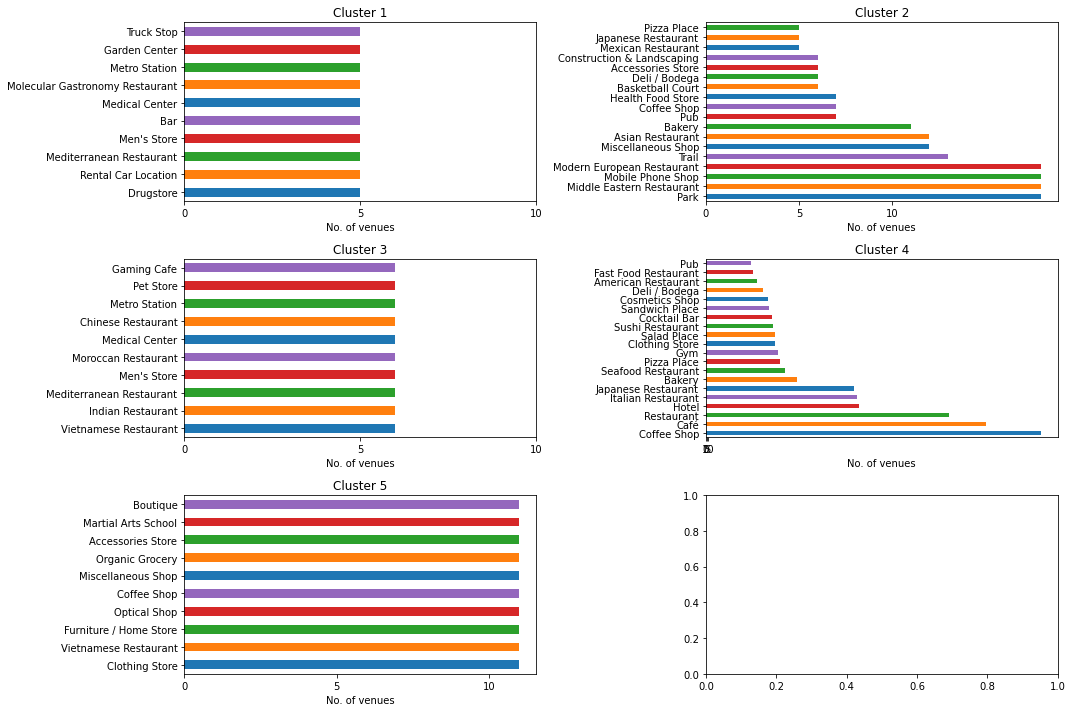

In [87]:
df_list = [venues1 ,venues2, venues3, venues4, venues5]
fig, axes = plt.subplots(3, 2)

count = 0
for r in range(3):
    for c in range(2):
        if count == 5:
            break
        else :
            df_list[count].value_counts().head(20).plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10),color=['C0', 'C1', 'C2', 'C3', 'C4'])
            axes[r,c].set_title('Cluster {}'.format(count+1))
            plt.sca(axes[r, c])
            plt.xticks(np.arange(0, 15, 5))
            plt.xlabel('No. of venues')
            count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

1. **Restaurant**

The neighborhoods in cluster 2 has the greatest number of restraurants and also it has different kinds of restraunts such as American, Sushi, Seafood,etc. Hence opening one here is not the best choice. One can think of opening a speicfic type of restraunt in Cluster 1 or 3 since there are only few specific types of places there. Cluster 5 is also a good choice for a Hotel or restraunts since there are less number of places there. Other factors such as places to explored in the vicinity by the customers can also be considered by looking at the venues in the plot.

2. **Medical Centre**

The neighborhoods 1 and 3 has notable number of medical stores where as other clusters hardly have any. Hence the suitable cluster would be the Cluster 2 and Cluster 4 and 5. Cluster 5 has a Martial Arts School and many other shops which gives an advantage.


Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

